In [1]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config


class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config
    @classmethod
    def from_config(cls, config):
        """Creates a layer from its config.
        This method is the reverse of `get_config`,
        capable of instantiating the same layer from the config
        dictionary. It does not handle layer connectivity
        (handled by Network), nor weights (handled by `set_weights`).
        Arguments:
            config: A Python dictionary, typically the
                output of get_config.
        Returns:
            A layer instance.
        """
        return cls(**config)


class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(latent_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [3]:
e_vocab = np.load('imp/e_vocab.npy',allow_pickle=True)
f_vocab = np.load('imp/f_vocab.npy',allow_pickle=True)
X_eng = np.load('imp/etp.npy',allow_pickle=True)
X_fr = np.load('imp/ftp.npy',allow_pickle=True)


In [4]:
X_train_eng, X_test_eng,X_train_fr, X_test_fr = train_test_split(X_eng,X_fr, test_size=0.05, random_state=42)
X_test_eng ,X_val_eng,X_test_fr ,X_val_fr = train_test_split(X_test_eng,X_test_fr, test_size=0.7, random_state=42)

In [5]:
print('train dataset size:',len(X_train_eng))
print('train label size',len(X_train_fr))
print('test dataset size:',len(X_test_eng))
print('test label size',len(X_test_fr))
print('val dataset size:',len(X_val_eng))
print('val label size',len(X_val_fr))

train dataset size: 166608
train label size 166608
test dataset size: 2630
test label size 2630
val dataset size: 6139
val label size 6139


In [6]:
X_e_train = X_train_eng
X_f_train = X_train_fr[:, :-1]
Y_train = X_train_fr[:, 1:]
X_e_test = X_test_eng
X_f_test = X_test_fr
X_e_val = X_val_eng
X_f_val = X_val_fr[:, :-1]
Y_val = X_val_fr[:, 1:]

In [7]:
embed_dim = 256
latent_dim = 2048
num_heads = 8
english_sequence_length = len(X_eng[0])
french_sequence_length = len(X_eng[0])
english_vocab_size = len(e_vocab.item())
french_vocab_size = len(f_vocab.item())


encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(english_sequence_length, english_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = tf.keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs =tf.keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = tf.keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(french_sequence_length, french_vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(french_vocab_size, activation="softmax")(x)
decoder = tf.keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [8]:
epochs = 30  # This should be at least 30 for convergence
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.5e-5)
transformer.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.summary()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("transformer_new.h5", save_best_only=True,save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=3,verbose=0,mode="auto",baseline=None,restore_best_weights=False,)
]

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3731200     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    3155456     positional_embedding[0][0]       
________________________________________________________________________________________

In [9]:
history = transformer.fit((X_e_train,X_f_train),Y_train, shuffle=True,epochs=epochs,batch_size=256,validation_data=((X_e_val,X_f_val),Y_val),callbacks=callbacks)

Epoch 1/30
651/651 [==============================] - 237s 356ms/step - loss: 0.7066 - accuracy: 0.4620 - val_loss: 0.4986 - val_accuracy: 0.6010
Epoch 2/30
651/651 [==============================] - 231s 355ms/step - loss: 0.4509 - accuracy: 0.6433 - val_loss: 0.3740 - val_accuracy: 0.6944
Epoch 3/30
651/651 [==============================] - 231s 355ms/step - loss: 0.3719 - accuracy: 0.7034 - val_loss: 0.3308 - val_accuracy: 0.7295
Epoch 4/30
651/651 [==============================] - 231s 355ms/step - loss: 0.3294 - accuracy: 0.7333 - val_loss: 0.3130 - val_accuracy: 0.7415
Epoch 5/30
651/651 [==============================] - 231s 355ms/step - loss: 0.3053 - accuracy: 0.7524 - val_loss: 0.3017 - val_accuracy: 0.7518
Epoch 6/30
651/651 [==============================] - 231s 355ms/step - loss: 0.2896 - accuracy: 0.7649 - val_loss: 0.2988 - val_accuracy: 0.7565
Epoch 7/30
651/651 [==============================] - 231s 355ms/step - loss: 0.2780 - accuracy: 0.7749 - val_loss: 0.2901 -

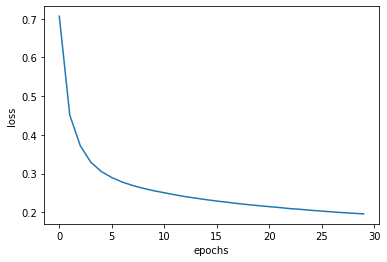

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [16]:
def token(text,vocab):
    temp_text = []
    temp_array = []
    for word in text:
        try:
            temp_array.append(vocab[str(word)])
        except:
            temp_array.append(vocab['<unk>'])
    temp_text.append(temp_array)
    return temp_text


In [17]:
spa_index_lookup = np.load('imp/f_vocab_rev.npy',allow_pickle=True)
max_decoded_sentence_length = 50


def decode_sequence(input_sentence):
    tokenized_input_sentence = input_sentence
    decoded_sentence = "<bos>"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = token(decoded_sentence.split(' '),f_vocab.item())
        tokenized_target_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_target_sentence, maxlen=50, padding="post")
        predictions = transformer([tokenized_input_sentence.reshape(1,50), tokenized_target_sentence.reshape(1,50)])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "<eos>":
            break
    return decoded_sentence

eng_index_lookup = np.load('imp/e_vocab_rev.npy',allow_pickle=True)
max_decoded_sentence_length = 50
def decode_english(input_seq):
    decoded_sentence = ""
    for i in range(max_decoded_sentence_length):
        sampled_token = eng_index_lookup[input_seq[i]]
        decoded_sentence += " " + sampled_token
        if sampled_token == "<eos>":
            break
    return decoded_sentence


for i in range(20):
    value = np.random.choice(np.arange(0,len(X_test_eng)))
    translated = decode_sequence(X_e_test[value])
    actual = decode_english(X_e_test[value])
    print('english:',actual)
    print('french:',translated)
    print('\n')

english:  <bos> i'm looking for a room for rent . <eos>
french: <bos> je cherche une chambre pour loyer . <eos>


english:  <bos> she's unfit for the job . <eos>
french: <bos> elle est en relation pour le poste . <eos>


english:  <bos> this can't wait until tomorrow . <eos>
french: <bos> cela ne peut pas attendre jusqu'à demain . <eos>


english:  <bos> i bought a watch . <eos>
french: <bos> j'ai acheté une montre . <eos>


english:  <bos> no one was helping us . <eos>
french: <bos> personne ne nous aide . <eos>


english:  <bos> my eyes are blue . <eos>
french: <bos> mes yeux sont jaunes . <eos>


english:  <bos> tom exaggerates . <eos>
french: <bos> tom a des soins . <eos>


english:  <bos> everyone got off the bus . <eos>
french: <bos> tout le monde a passé le bus . <eos>


english:  <bos> now that he is old , it is your duty to go look after him . <eos>
french: <bos> maintenant qu'il est vieux , c'est ton devoir de faire ça va le prendre soin de lui . <eos>


english:  <bos> i hav